In [2]:
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import graphviz  # To visualize our learned decision trees.

plt.rcParams.update({'font.size': 14})

In [3]:
# Let's revisit our old friend, "titanic", again.
titanic = sns.load_dataset('titanic')  # Contains about a third of the Titanic data

# Convert string-valued columns to numerical categorical values.
for column in ('survived', 'sex', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town'):
  titanic[column] = pd.Categorical(titanic[column]).codes
titanic  # Preview the data

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,1,22.0,1,0,7.2500,2,2,1,1,-1,2,no,False
1,1,1,0,38.0,1,0,71.2833,0,0,2,0,2,0,yes,False
2,1,3,0,26.0,0,0,7.9250,2,2,2,0,-1,2,yes,True
3,1,1,0,35.0,1,0,53.1000,2,0,2,0,2,2,yes,False
4,0,3,1,35.0,0,0,8.0500,2,2,1,1,-1,2,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,2,1,1,1,-1,2,no,True
887,1,1,0,19.0,0,0,30.0000,2,0,2,0,1,2,yes,True
888,0,3,0,NaN,1,2,23.4500,2,2,2,0,-1,2,no,False
889,1,1,1,26.0,0,0,30.0000,0,0,1,1,2,0,yes,True


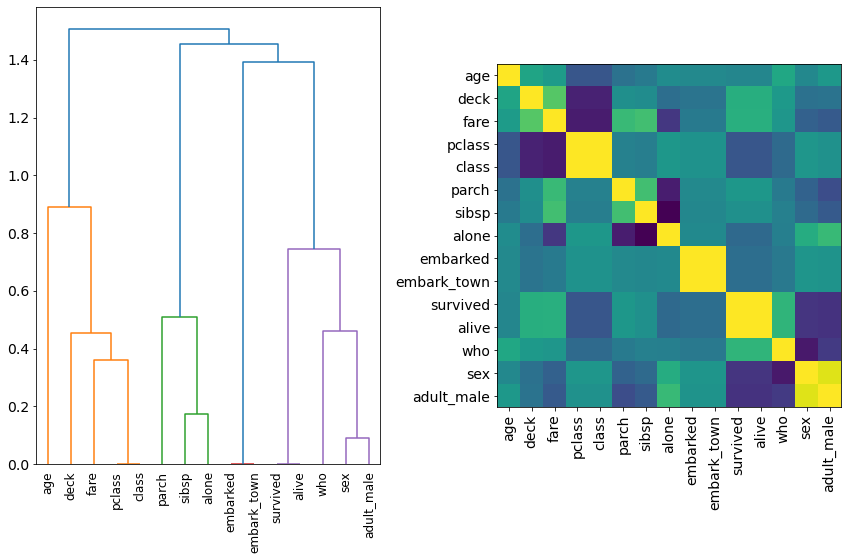

In [4]:
# Before we move forward, let's look at our features, generating a diagram like
# the one we talked about in Lecture 7.
# Code based on: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py
import scipy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = scipy.stats.spearmanr(titanic).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = scipy.cluster.hierarchy.ward(scipy.spatial.distance.squareform(distance_matrix))
dendro = scipy.cluster.hierarchy.dendrogram(
    dist_linkage, labels=titanic.columns.values.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()
# Anything stand out? Which features might we remove? And what's about to be a
# huge problem for predicting 'survived' from the other featuers?

In [ ]:
# Drop 'alive', 'pclass'
titanic.drop(['alive', 'pclass'], axis=1, inplace=True)

In [ ]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy="most_frequent")  # Using most-frequent for categorical data.
imputed_titanic = imp.fit_transform(titanic)  # This creates a new Numpy array with missing values imputed.
titanic = pd.DataFrame(imputed_titanic, columns=titanic.columns, index=titanic.index)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(titanic.drop("survived", axis=1), titanic["survived"], test_size=0.2, random_state=5, shuffle=True)
y_train = y_train.astype('int')  # For some reason these are just 'object' typed when extracted.
y_test = y_test.astype('int')
X_train

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(
	criterion="entropy",
	max_depth=3,  # What happens if you lower or raise this value?
	class_weight=None,
	random_state=0
)
model.fit(X_train, y_train)
print(f'DT, depth=3 acc: {model.score(X_test, y_test):.2%}')

In [ ]:
# Just for reference, train a few baselines
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression

gnb = GaussianNB(var_smoothing=0.0)
gnb.fit(X_train, y_train)
print(f'Gaussian NB acc: {gnb.score(X_test, y_test):.2%}')

bnb = BernoulliNB(alpha=1)
bnb.fit(X_train, y_train)
print(f'Bernoulli NB acc: {bnb.score(X_test, y_test):.2%}')

lr = LogisticRegression(
  penalty="none",
	class_weight=None,
	random_state=0,
	solver="lbfgs",
	multi_class="multinomial",
	max_iter=500)
lr.fit(X_train, y_train)
print(f'Logistic Regression acc: {lr.score(X_test, y_test):.2%}')

In [ ]:
# So what's actually being learned? Consider starting with a depth=1 tree.
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(model, feature_names=X_train.columns.values, out_file=None)
graph = graphviz.Source(dot_data)
graph

In [ ]:
# Why was adult male the first choice?
sns.histplot(data=titanic, x="adult_male", hue="survived", multiple="dodge")
# Ignoring the ugly x-axis, clear how each node high purity.

In [ ]:
# How about RandomForests
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=3, random_state=0)  # This algorithm involves randomness!
rfc.fit(X_train, y_train)
print(f'RF, depth=3 acc: {rfc.score(X_test, y_test):.2%}')  # No gain in accuracy. The dataset is a bit small.

In [ ]:
# Code based on: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py
from sklearn.inspection import permutation_importance

result = permutation_importance(rfc, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(rfc.feature_importances_)
tree_indices = np.arange(0, len(rfc.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, rfc.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
feature_names = X_train.columns.values
ax1.set_yticklabels(feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(rfc.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=feature_names[perm_sorted_idx],
)
fig.tight_layout()
plt.show()
# Note how the two don't always match. In general, feature importance (which here
# refers to mean decrease in purity across all DTs) can be somewhat less informative
# then permutation importance because they skew towards common features and are 
# estimated on training data.

In [ ]:
# For completeness, gradient boosted decision trees. Not any better either.
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=0)
gbc.fit(X_train, y_train)
print(f'Boosted DT, depth=3 acc: {gbc.score(X_test, y_test):.2%}')